In [1]:
# this code is written by Changyi Yang used for DS Discovery program

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

import plotly.graph_objs as go
import plotly.offline as pyo

In [2]:
df = pd.read_csv('cesium.csv')
df

,t,['0.0:5.33e-07'],['5.33e-07:1.07e-06'],['1.07e-06:1.6e-06'],['1.6e-06:2.13e-06'],['2.13e-06:2.67e-06'],['2.67e-06:3.2e-06'],['3.2e-06:3.73e-06'],['3.73e-06:4.27e-06'],['4.27e-06:4.8e-06'],...,['0.000101:0.000102'],['0.000102:0.000102'],['0.000102:0.000103'],['0.000103:0.000103'],['0.000103:0.000104'],['0.000104:0.000104'],['0.000104:0.000105'],['0.000105:0.000106'],['0.000106:0.000106'],['0.000106:0.000107']
0,50.0,272,0,0,0,0,0,0,0,0,...,0,2,0,2,3,3,2,1,0,2
1,51.0,243,0,0,0,0,0,0,0,0,...,4,0,2,3,3,1,0,1,0,0
2,52.0,236,0,0,0,0,0,0,0,0,...,4,3,3,2,2,0,2,1,1,0
3,53.0,222,0,0,0,0,0,0,0,0,...,1,0,2,3,2,2,2,3,3,2
4,54.0,244,0,0,0,0,0,0,0,0,...,1,4,2,2,1,5,2,2,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,191.0,286,0,0,0,0,0,0,0,0,...,1,2,2,7,3,2,4,3,5,4
142,192.0,275,0,0,0,0,0,0,0,0,...,3,1,4,1,6,3,2,2,2,4
143,193.0,276,0,0,0,0,0,0,0,0,...,3,2,3,3,4,5,6,5,2,2
144,194.0,285,0,0,0,0,0,0,0,0,...,1,1,3,2,2,4,5,4,5,8


In [3]:
# define the dataset classes
from sklearn.preprocessing import StandardScaler, MinMaxScaler


class ReactorData(Dataset):
    def __init__(self,file_name,cesium_file_name, sequence_length, start_percent = 0, end_percent = 1):
        data = pd.read_csv(file_name, skiprows=[0]) # skip the first line
        cesium_data = pd.read_csv(file_name, skiprows=[0])
        length = data.shape[0]
        data = data[ int(length * start_percent)  : int(length * end_percent)]
        cesium_data = cesium_data[ int(length * start_percent)  : int(length * end_percent)]
        
        
        # print(data.shape)
        
        
        self.labels = cesium_data.iloc[:, 1:] #we want to predict the 201 bin counts not the last column. #add row of 0s
        self.data = data.iloc[:, 1:] # skip the first time column
        
        mm = MinMaxScaler()
        self.ss_data = StandardScaler()
        self.ss_labels = StandardScaler()

        self.data = self.ss_data.fit_transform(self.data)
        self.labels = self.ss_labels.fit_transform(self.labels) 
        
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.labels)//self.sequence_length
    
    def __getitem__(self,idx):
        idx = idx * self.sequence_length
        
        return (torch.tensor(self.data[idx : idx+ self.sequence_length])).double(), \
    (torch.tensor(self.labels[idx : idx+ self.sequence_length])).double()

        

In [4]:
# load the data
training_data = ReactorData('fluence.csv','cesium.csv', sequence_length= 10, start_percent= 0, end_percent= 0.75) 
testing_data = ReactorData('fluence.csv','cesium.csv', sequence_length= 10, start_percent= 0.75, end_percent= 1)


In [5]:
# define the neural nets
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_nums_layer, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        
        self.LSTM = nn.LSTM(input_dim, hidden_dim, lstm_nums_layer, batch_first = True)
        self.dropout = nn.Dropout(dropout)
        
        self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input):
        # print(input.shape)
        
        hidden_state, _ = self.LSTM(input)
        
        # print(hidden_state.shape)
        output = self.dropout(hidden_state)
        output = self.hidden_to_output(output)
        
        
        return output

In [12]:
# train the model

input_dim = training_data[0][0].shape[1]
output_dim = training_data[0][1].shape[1] #should be 201


# print(output_dim)

# some adjustable hyper-parameters
hidden_dim = 256
num_hidden_layers = 1
batch_size = 5
learning_rate = 1e-3
weight_decay = 1e-5
epoch_num = 300
dropout = 0.2

model = SimpleLSTM(input_dim, hidden_dim, output_dim, num_hidden_layers, dropout)
model = model.double()

train_dataloader = DataLoader(training_data, batch_size = batch_size)


# the chosn loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay)



for epoch in range(epoch_num):
    
    for batch, (X, y) in enumerate(train_dataloader):
        

        
        model.zero_grad()
        
        pred = model(X)
        #print(pred) # would this be the outputs at each bin?
        # print(X.shape)
        # print(y.shape)
        
        loss = loss_fn(pred, y)
        
        # backpropagation
        
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        
    if epoch % 5 == 0:
        print("The loss is {} in epoch {}".format(loss ,epoch))
            

print(f"The training is ended, the final loss is {loss}.")
print("Bye")

The loss is 0.6754672414827737 in epoch 0
The loss is 0.6046577292938932 in epoch 5
The loss is 0.5395658145070782 in epoch 10
The loss is 0.4769278604809392 in epoch 15
The loss is 0.41037162506021024 in epoch 20
The loss is 0.3419676391920456 in epoch 25
The loss is 0.28601650489205693 in epoch 30
The loss is 0.22837444429406675 in epoch 35
The loss is 0.1874857340928292 in epoch 40
The loss is 0.1587584701539866 in epoch 45
The loss is 0.13265891478809846 in epoch 50
The loss is 0.11370592372945137 in epoch 55
The loss is 0.10487205668705143 in epoch 60
The loss is 0.09353420304733906 in epoch 65
The loss is 0.08499239326887094 in epoch 70
The loss is 0.08211260786252626 in epoch 75
The loss is 0.07664515399101628 in epoch 80
The loss is 0.07121004877153343 in epoch 85
The loss is 0.0686764748319758 in epoch 90
The loss is 0.06962699226908287 in epoch 95
The loss is 0.06749157133420304 in epoch 100
The loss is 0.06694068428653575 in epoch 105
The loss is 0.060876408748687987 in epoc

In [15]:
# visualize the training output

import matplotlib.pyplot as plt


X_train = (torch.tensor(training_data.data)).double()
y_train = (torch.tensor(training_data.labels)).double()


In [16]:
# visualize the test output

import matplotlib.pyplot as plt


X_test = (torch.tensor(testing_data.data)).double()
y_test = (torch.tensor(testing_data.labels)).double()

y_pred = model(X_test)

loss = nn.MSELoss()
print(loss(y_pred, y_test).item())

# plt.figure()
# plt.plot(y_test, label = "Real")     
# plt.plot(y_pred.detach().numpy(), label = "Predict")
# plt.legend()
X_test.shape

0.5290308456466564


torch.Size([37, 201])

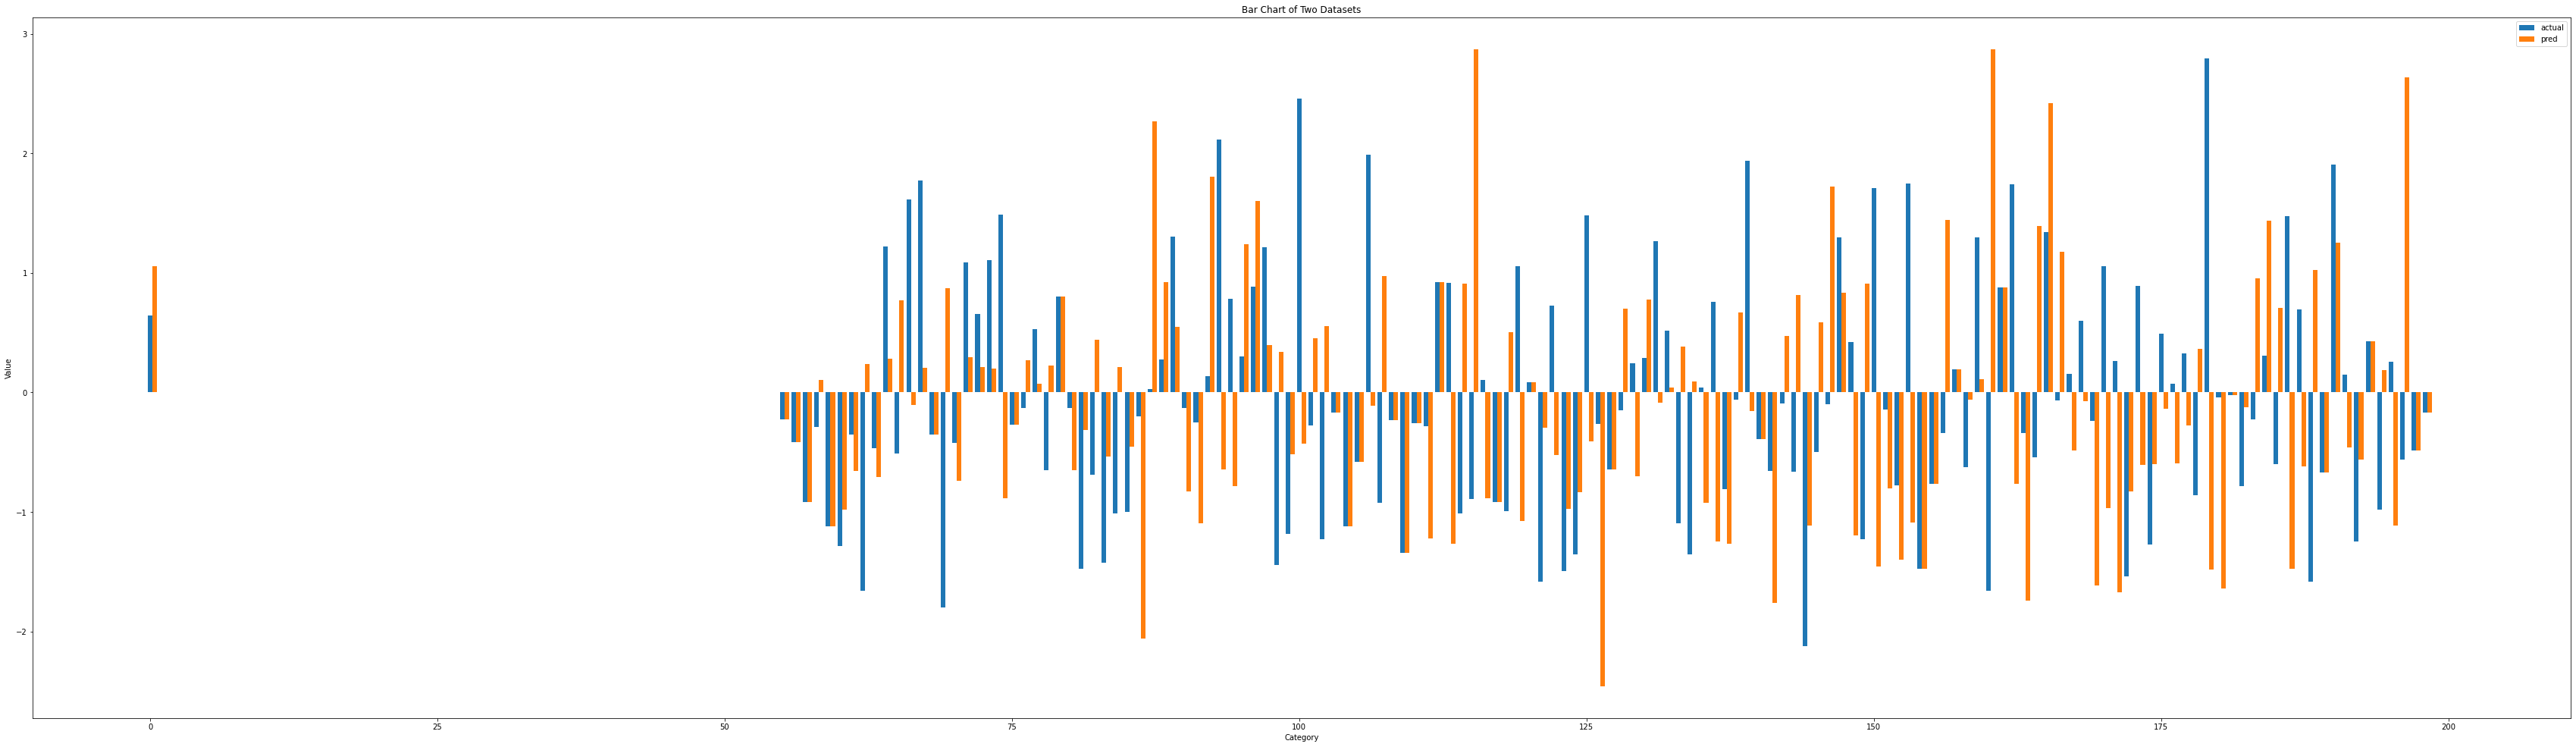

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate two sets of random data
# actual = testing_data.ss_data.inverse_transform(X_test)[26][25:]
# predict = testing_data.ss_labels.inverse_transform(y_test)[27][25:]

actual =(X_test)[26]
predict =(y_test)[27]

# Define the x-axis labels
labels = np.arange(0,201)

# Set the width of each bar
width = .4
p = plt.figure(figsize=(60,17))

# Plot the bar charts
plt.bar(labels, actual, width, label='actual')
plt.bar([x + width for x in range(len(labels))], predict, width, label='pred')

# Add a legend and axis labels
plt.legend(loc='upper right')
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Bar Chart of Two Datasets')

# Show the plot
plt.show()


In [18]:
# create sample data
df = pd.DataFrame({
    'bins': np.arange(0,201),
    'real': X_test[0],
    'predict': y_test[1]
})

# create traces for the two bar charts
trace1 = go.Bar(x=df['bins'], y=df['real'], name='real')
trace2 = go.Bar(x=df['bins'], y=df['predict'], name='predict')

# create a data list containing the traces
data = [trace1, trace2]

# set the layout of the chart
layout = go.Layout(title='scaled at timestep 0 Bar Chart')

# create the figure object
fig = go.Figure(data=data, layout=layout)

# plot the figure and show the chart in an interactive HTML file
pyo.plot(fig, filename='scaledindex0.html')


'scaledindex0.html'

In [11]:
# create sample data
df2 = pd.DataFrame({
    'bins': np.arange(0,201),
    'real': testing_data.ss_data.inverse_transform(X_test)[0],
    'predict': testing_data.ss_labels.inverse_transform(y_test)[1]
})

# create traces for the two bar charts
trace1 = go.Bar(x=df2['bins'], y=df2['real'], name='real')
trace2 = go.Bar(x=df2['bins'], y=df2['predict'], name='predict')

# create a data list containing the traces
data = [trace1, trace2]

# set the layout of the chart
layout = go.Layout(title='unscaled time step 0 Bar Chart')

# create the figure object
fig = go.Figure(data=data, layout=layout)

# plot the figure and show the chart in an interactive HTML file
pyo.plot(fig, filename='unscaledindex0.html')


'unscaledindex0.html'